# Scale limits of Hawkes process

This notebook demonstrates some results in the paper

 + [Modeling microstructure noise with mutually
exciting point processes
](https://arxiv.org/pdf/1101.3422.pdf)

Consider a stochastic process $\{X_t\}_{t\geq 0}$. The quadratic variation of $X_t$ over a time period $[0,T]$ is (realized volatility)

$$\hat{C}(\tau) = \frac{1}{T} \sum_0^{T/\tau} \lvert X_{(n+1)\tau} - X_{n\tau} \rvert^2$$

## Microscope noise
The stochastic process is contructed by two point processes $N_1(t)$ and $N_2(t)$ having intensity $\mu$. Then $X(t)$ is constructed by the difference between the jump

$$X(t) = N_1(t) - N_2(t)$$

At the limit, the scale of $(t)$ converges to a standard Brownian motion:

$$\lim_{T\to +\infty} \frac{1}{\sqrt{T}}X(tT) = \sqrt{2\mu} B(t), \quad t \in [0,1]$$



In [46]:
import numpy as np
import matplotlib.pyplot as plt

### How to sample Poisson process?
**Sample arrival time from Poisson distribution**
From the p.d.f. $f(t) = \mu e^{-\mu t}$, we have the c.d.f. $F(t) = 1 - e^{-\mu t}$. Use the *inverse transform sampling*, we sample an **arrival time** by first sample 

$$u \sim U(0,1), \quad \tau = -\frac{\ln (u)}{\mu}$$

Sample the Poisson process by repeating this procedure and arrival time will be added or concatenated w.r.t. the current arrival time

In [6]:
def sample_poisson(intensity):
    u = np.random.rand()
    return - np.log(u) / intensity

In [69]:
def sample_point_process(intensity, a=0, b=1, n_steps=100):
    current = 0.
    arrival_times = [0]
    while current <= b:
        event = sample_poisson(intensity)
        arrival_times.append(current + event)
        current += event
    if len(arrival_times) == 0:
        print(f"No event occurs in this time interval [{a}, {b}]. Maybe intensity is small?")
    arrival_times = np.array(arrival_times)
    
    # print(arrival_times)
    hist, times = np.histogram(arrival_times, bins=n_steps, range=(a,b))
    return hist.cumsum(), times[:-1]
    

In [78]:
def scale_limit_point_process(intensity, T, n_steps=100):
    N1, times = sample_point_process(intensity, a=0, b=T, n_steps=n_steps)
    N2, times = sample_point_process(intensity, a=0, b=T, n_steps=n_steps)
    lhs = (N1 - N2)/np.sqrt(T)
    return lhs, times / T

Sampling Brownian motion $B_t$
We usually divide the time interval into small parts. In each part, an increment $\Delta B_t \sim \mathcal{N}(0, \sqrt(\Delta t))$. 

Aggregate these increments we obtain a sample path of the Browian motions

In [ ]:
def sample_brownian(a=0, b=1, n_steps=100):
    sqrt_delta_t = np.sqrt((b-a)/n_steps)
    delta_b = np.random.randn(n_steps) * sqrt_delta_t
    brownian_motion = delta_b.cumsum()
    times = np.linspace(a, b, n_steps)
    return brownian_motion, times

## Compare between the scale limit and Brownian motion
The following plots justifies visually the convergence

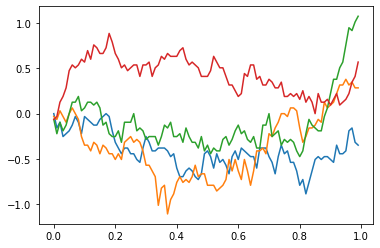

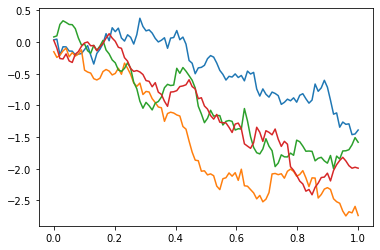

In [82]:
T = 1000
intensity = 0.5
plt.figure()
for _ in range(4):
    Xs, times = scale_limit_point_process(intensity, T)
    plt.plot(times, Xs)
    
plt.figure()
for _ in range(4):
    b, times = sample_brownian(0, 1)
    plt.plot(times, b * np.sqrt(2*intensity))
    

### The case of linear Hawkes process

Now we extend from point processes to linear Hawkes process (intensity is now a stochastic process). Formally, intensity $\lambda_i(t), i=1,2$ is written

$$
\lambda_i(t) = \lim_{\Delta \to 0} \frac{\mathbb{E}[N_i(t + \Delta) - N_i(t)| \mathcal{F}_t]}{\Delta}
$$

This reflects the average rate of change for the counting. In terms of modeling, Hawkes processes (in this case) is defined as

$$\lambda_i(t) = \mu_i + \int_{-\infty}^t \varphi_{ii}(t-u)dN_i(u) + \int_{-\infty}^t \varphi_{ij}(t-u) dN_j(u).$$

Note that there is a condition that the $L^1$ norm of $\varphi_{ij}$ is smaller than $1$.

The model is further simplified

$$\lambda_1(t) = \mu + \int_{-\infty}^t \varphi(t-s)dN_2(s), \quad \lambda_2(t) = \mu + \int_{-\infty}^t \varphi(t-s)dN_1(s)$$

where $\varphi(t)=\alpha e^{-\beta t} 1_{\mathbb{R}^+}(t)$ with $\alpha / \beta \leq 1$.

#### Signature plot
This quantity is measured by

$$C(\tau) = \mathbb{E}[\hat{C}(\tau)] = \frac{1}{\tau}\mathbb{E}[\lvert X((n+1)\tau) - X(n\tau)\rvert^2] = \frac{1}{\tau}\mathbb{E}[X(\tau)^2].$$

This can be directly estimated as
$$C(\tau) = \Lambda\left(\kappa^2 + (1 - \kappa^2)\frac{1 - e^{\gamma \tau}}{\gamma \tau}\right), \quad, \Lambda = \frac{2\mu}{1 - \lvert\lvert \varphi \rvert\rvert_1}, \quad \kappa = \frac{1}{1 + \lvert\lvert \varphi \rvert\rvert_1}$$

In [88]:
def compute_exact_signature(tau, mu, alpha, beta):
    assert alpha < beta, "Make sure of stability condition"
    norm_1 = alpha / beta
    Lambda = 2 * mu / (1 - norm_1)
    kappa = 1 / (1 + norm_1)
    gamma = alpha + beta
    return Lambda * (kappa ** 2 +(1-kappa**2)*(1 - np.exp(-gamma * tau))/(gamma * tau))

/tmp/ipykernel_11074/336569238.py:7: RuntimeWarning: invalid value encountered in true_divide
  return Lambda * (kappa ** 2 +(1-kappa**2)*(1 - np.exp(-gamma * tau))/(gamma * tau))


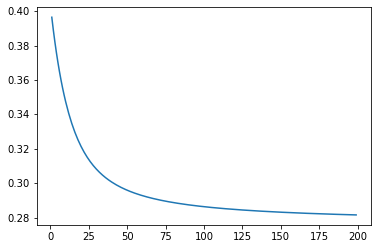

In [92]:
mu, alpha, beta = 0.16, 0.023, 0.11 # from the paper
tau = np.arange(0, 200)
C = compute_exact_signature(tau, mu, alpha, beta)
plt.plot(tau[1:], C[1:])
# Figure 1 in the paper

In [100]:
class ExponentialIntensity():
    
    def __init__(self, base_intensity, alpha, beta):
        assert alpha < beta
        self.base_intensity = base_intensity
        self.alpha = alpha
        self.beta = beta
        
    def __call__(self, t, arrival_time):
        if t == 0:
            return self.base_intensity
        if len(arrival_time) == 0:
            return self.base_intensity
        time_different = t - np.array(arrival_time)
        phi = np.exp(-beta * time_different) * alpha    
        return self.base_intensity + np.sum(phi)
    
        

## Sample Hawkes process

The sampling procedure follows a thinning procedure (see [this](https://arxiv.org/pdf/1708.06401.pdf))
1. Choose $M$ s.t. $\lambda_i(t) < M$
2. Sample Poison process with intensity $M$
3. Reject a point with probability $M - \lambda_1(t) - \lambda_2(t)
4. If accept, mark it as $N_1(t)$ with prob. $\lambda_1(t)$ or $N_2(t)$ with probability $\lambda_2(t)$

In [121]:
def thinning(mu, alpha, beta, a=0, b=42*3600, n_steps=42*3600, M=1):
    
    arrival_1 = []
    arrival_2 = []
    
    intensity = ExponentialIntensity(mu, alpha, beta)
    current = 0.
    
    while True:
    
        tau = sample_poisson(intensity=M)
        current += tau
        if current > b:
            break
        update_intensity_1 = intensity(current, arrival_2)
        update_intensity_2 = intensity(current, arrival_1)
        
        s = np.random.rand()
        
        if s < (M - update_intensity_1 - update_intensity_2) / M:
            # reject
            pass
        elif s < (M-update_intensity_2)/M:
            arrival_1 += [current]
        else:
            arrival_2 += [current]
            
    hist_1, times = np.histogram(arrival_1, bins=n_steps, range=(a,b))
    hist_2, times = np.histogram(arrival_2, bins=n_steps, range=(a,b))
    return hist_1.cumsum(), hist_2.cumsum(), times
    

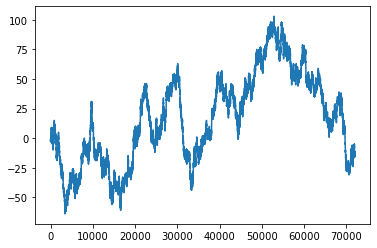

In [138]:
n_hours = 20
T = n_hours * 3600 # in seconds
N1, N2, times = thinning(mu, alpha, beta, b=T, n_steps=T)
plt.plot(times[:-1], N1-N2)

#### Compute empirical (realized) signature plot
This is the realized volatility described above
$$
\hat{C}(\tau) = \frac{1}{T}\sum_{n=0}^{T/\tau}|X((n+1)\tau) - X(n\tau)|^2
$$

In [139]:
def compute_realized_signature(X, max_tau=200):
    T = len(X)
    signature = []
    for tau in range(1, max_tau + 1):
        max_n = int(np.floor(T/tau)) -1 
        diff = 0
        for n in range(max_n):
            i = (n+1)*tau
            j = n * tau
            diff += np.abs(X[i] - X[j])**2
        signature += [diff / T]
    return signature

In [140]:
X = N1 - N2
C_hat = compute_realized_signature(X)

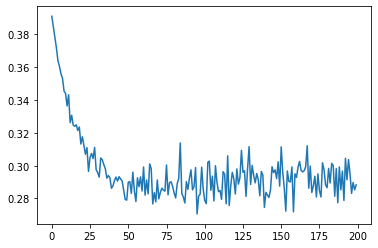

In [142]:
plt.plot(C_hat)
# the result resembles Figure 1 in the paper

### Some remarks
+ Brownian motion is well-known in many pricing problems but it is a too strong assumption
+ Instead of using Brownian motion, the jump process is more suitable to model financial time series. (Recent orders leads to more order. Also the convergence leads to Brownian in macroscope views)
+ Using the above construction from two Hawkes processes is more flexible than just two point processes by using different kernels 

Some more reference:
 + [Limit theorems for nearly unstable Hawkes processes](https://arxiv.org/pdf/1310.2033.pdf)
 + [Quadratic Hawkes processes for financial prices](https://arxiv.org/abs/1509.07710) (Different type of Hawkes process but the technique - scale-limit - is the same)